# Proyecto Grupo 5 - Análisis Musical en Spotify

## Codigo

### Cargando librerias

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd

import sqlite3
import datetime
import typing

### Config de notebook

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 35)
pd.set_option('display.max_rows', 20)

### Cargando datos

Se utilizan [los siguientes datos de kaggle](https://www.kaggle.com/datasets/maltegrosse/8-m-spotify-tracks-genre-audio-features). Estos se encuentran contenidos en una BDD `spotify.sqlite`, la cual pondremos en una carpeta `data`.

In [3]:
# funcion para cargar las tablas de la base de datos en un diccionario de dataframes
def load_data():
  # conexion a la base de datos
  conn = sqlite3.connect(
    database='data/spotify.sqlite'
  )
  # para que no haya problemas con los caracteres especiales
  conn.text_factory = lambda b: b.decode(encoding = 'utf-8', errors = 'ignore')
  
  # lista de tablas de la base de datos
  tables = [
    "r_albums_artists",
    "r_albums_tracks",
    "r_artist_genre",
    "r_track_artist",
    "genres",
    "albums",
    "artists",
    "audio_features",
    "tracks",
  ]

  # diccionario de dataframes
  dataframes : typing.Dict[str, pd.DataFrame] = {}
  
  # cargar cada tabla en un dataframe
  for table in tables:
    dataframes[table] = pd.read_sql_query(
      sql = f"SELECT * FROM {table}",
      con = conn
    )
  
  # cerrar la conexion a la base de datos
  conn.close()

  return dataframes

# ejecutar la funcion
dataframes : typing.Dict[str, pd.DataFrame] = load_data()
[
  tracks, artists, albums, genres, audio_features, 
  r_albums_artists, r_albums_tracks, r_artist_genre, r_track_artist
] = [
  dataframes['tracks'], dataframes['artists'], dataframes['albums'], dataframes['genres'], dataframes['audio_features'] ,
  dataframes['r_albums_artists'], dataframes['r_albums_tracks'], dataframes['r_artist_genre'], dataframes['r_track_artist']
]
# ver las tablas cargadas
dataframes.keys()

dict_keys(['r_albums_artists', 'r_albums_tracks', 'r_artist_genre', 'r_track_artist', 'genres', 'albums', 'artists', 'audio_features', 'tracks'])

### Formato de las tablas

In [4]:
info_df = pd.DataFrame()
info_df['tabla'] = dataframes.keys()
info_df['filas'] = [dataframes[i].shape[0] for i in dataframes.keys()]
info_df['columnas'] = [dataframes[i].shape[1] for i in dataframes.keys()]
info_df['nombre_columnas'] = [list(dataframes[i].columns) for i in dataframes.keys()]

info_df.set_index('tabla', inplace=True)
info_df

,filas,columnas,nombre_columnas
tabla,,,
r_albums_artists,921486,2,"[album_id, artist_id]"
r_albums_tracks,9900173,2,"[album_id, track_id]"
r_artist_genre,487386,2,"[genre_id, artist_id]"
r_track_artist,11840402,2,"[track_id, artist_id]"
genres,5489,1,[id]
albums,4820754,6,"[id, name, album_group, album_type, release_date, popularity]"
artists,1066031,4,"[name, id, popularity, followers]"
audio_features,8740043,15,"[id, acousticness, analysis_url, danceability, duration, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence]"
tracks,8741672,10,"[id, disc_number, duration, explicit, audio_feature_id, name, preview_url, track_number, popularity, is_playable]"


### Estadisticas y exploración inicial

Las tablas `r_albums_artists`, `r_albums_tracks`, `r_artist_genre` solamente contienen ids, por lo que no contienen estadisticas interesantes

#### albums

In [15]:
albums.head()

,id,name,album_group,album_type,release_date,popularity
0,2jKoVlU7VAmExKJ1Jh3w9P,"Alkaholik (feat. Erik Sermon, J Ro & Tash)",,album,954633600000,0
1,4JYUDRtPZuVNi7FAnbHyux,"Flava in Ya Ear Remix (feat. Notorious B.I.G., L.L. Cool J, Busta Rhymes, Rampage)",,single,757382400000,0
2,6YjKAkDYmlasMqYw73iB0w,Bitch Please II,,album,959040000000,0
3,2YlvHjDb4Tyxl4A1IcDhAe,Just Dippin',,compilation,1104537600000,0
4,3UOuBNEin5peSRqdzvlnWM,Still D.R.E.,,album,942710400000,0


In [17]:
albums.shape

(4820754, 6)

In [18]:
albums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4820754 entries, 0 to 4820753
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   id            object
 1   name          object
 2   album_group   object
 3   album_type    object
 4   release_date  int64 
 5   popularity    int64 
dtypes: int64(2), object(4)
memory usage: 220.7+ MB


In [19]:
albums.describe().apply(lambda s: s.apply(lambda x: format(x, '.3f')))

,release_date,popularity
count,4820754.000,4820754.000
mean,1222681215510.437,2.152
std,469358868052.110,8.074
min,-62135769600000.000,0.000
25%,1139961600000.000,0.000
50%,1311033600000.000,0.000
75%,1414713600000.000,0.000
max,1644537600000.000,100.000


En base a las celdas anteriores, consideramos: 

- Formalizar `release_date`, estan en formato timestamp unix, por lo que seria conveniente tener esa informacion como fecha. \
  Ademas debemos tener cuidado con los timestamps negativos, los que nos pueden traer problemas (algunos van al año 0)
- Analizar si la popularidad del album es importante, pues 75% de sus valores es 0 en un rango de 0 a 100


In [20]:
albums['album_type'].value_counts()

album_type
album          3612835
compilation     766770
single          441149
Name: count, dtype: int64

In [21]:
albums['album_group'].value_counts()

album_group
    4820754
Name: count, dtype: int64

In [22]:
(albums['album_group'] == '').value_counts()

album_group
True    4820754
Name: count, dtype: int64

En base a las celdas anteriores, consideramos: 

- `album_group`, que solo contiene strings vacios, es candidato a eliminar.

#### artists

In [23]:
artists.head()

,name,id,popularity,followers
0,Xzibit,4tujQJicOnuZRLiBFdp3Ou,69,1193665
1,Erick Sermon,2VX0o9LDIVmKIgpnwdJpOJ,54,142007
2,J. Ro,3iBOsmwGzRKyR0vs2I61xP,45,158
3,Tash,22qf8cJRzBjIWb2Jc4JeOr,48,3421
4,Craig Mack,4akj4uteQQrrGxhX9Rjuyf,55,161966


In [24]:
artists.shape

(1066031, 4)

In [25]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066031 entries, 0 to 1066030
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   name        1066031 non-null  object
 1   id          1066031 non-null  object
 2   popularity  1066031 non-null  int64 
 3   followers   1066031 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 32.5+ MB


In [26]:
artists.describe().apply(lambda s: s.apply(lambda x: format(x, '.3f')))

,popularity,followers
count,1066031.000,1066031.000
mean,5.418,7012.360
std,11.944,208718.429
min,0.000,0.000
25%,0.000,0.000
50%,0.000,0.000
75%,3.000,101.000
max,98.000,78503098.000


Aqui no consideramos modificar los datos. Pero hay que considerar un analisis mas en profundidad de las columnas de popularidad y seguidores.

#### tracks

In [27]:
tracks.head()

,id,disc_number,duration,explicit,audio_feature_id,name,preview_url,track_number,popularity,is_playable
0,1dizvxctg9dHEyaYTFufVi,1,275893,1,1dizvxctg9dHEyaYTFufVi,Gz And Hustlas (feat. Nancy Fletcher),,12,0,NaN
1,2g8HN35AnVGIk7B8yMucww,1,252746,1,2g8HN35AnVGIk7B8yMucww,Big Poppa - 2005 Remaster,https://p.scdn.co/mp3-preview/770e023eb0318270ecc5caa018d758e5e0844de9?cid=cde021ca5d3e42a8bd440f1004a562dc,13,77,NaN
2,49pnyECzcMGCKAqxfTB4JZ,3,315080,0,49pnyECzcMGCKAqxfTB4JZ,"You Were Born - Early Version Of ""One Of The Three"" / Outtake",,6,8,1.0
3,4E5IFAXCob6QqZaJMTw5YN,1,240800,1,4E5IFAXCob6QqZaJMTw5YN,Poppin' Them Thangs,https://p.scdn.co/mp3-preview/f3b556ced9657f8987d2c981014205244daf4540?cid=cde021ca5d3e42a8bd440f1004a562dc,2,70,NaN
4,1gSt2UlC7mtRtJIc5zqKWn,2,203666,0,1gSt2UlC7mtRtJIc5zqKWn,"It's Hard To Say ""I Do"", When I Don't",,2,50,NaN


In [28]:
tracks.shape

(8741672, 10)

In [29]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8741672 entries, 0 to 8741671
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                object 
 1   disc_number       int64  
 2   duration          int64  
 3   explicit          int64  
 4   audio_feature_id  object 
 5   name              object 
 6   preview_url       object 
 7   track_number      int64  
 8   popularity        int64  
 9   is_playable       float64
dtypes: float64(1), int64(5), object(4)
memory usage: 666.9+ MB


In [30]:
tracks.describe().apply(lambda s: s.apply(lambda x: format(x, '.3f')))

,disc_number,duration,explicit,track_number,popularity,is_playable
count,8741672.000,8741672.000,8741672.000,8741672.000,8741672.000,413800.000
mean,1.137,236968.739,0.067,10.932,6.118,0.875
std,0.996,159688.660,0.250,22.722,10.580,0.330
min,1.000,0.000,0.000,1.000,0.000,0.000
25%,1.000,169200.000,0.000,4.000,0.000,1.000
50%,1.000,216160.000,0.000,7.000,1.000,1.000
75%,1.000,273887.000,0.000,12.000,8.000,1.000
max,63.000,19672058.000,1.000,1522.000,100.000,1.000


A partir de las celdas anteriores, consideramos:

- `disc_number` es candidato a eliminar, pues tiene poca varianza y algunos outliers.
- Analizar si `track_number` puede ser una columna util o no. Parece tener outliers (ver `max`).
- `is_playable` es candidato a eliminar, pues su count indica que muchos de sus valores son nulos.

In [31]:
tracks['disc_number'].value_counts()

disc_number
1     8204349
2      348328
3       80298
4       38099
5       20324
       ...   
63          6
57          5
59          5
62          4
58          3
Name: count, Length: 63, dtype: int64

In [32]:
tracks['disc_number'].max()

63

In [33]:
tracks['disc_number'].var()

0.9917664238559349

In [34]:
tracks['track_number'].value_counts()

track_number
1       806135
2       680726
3       652969
4       632889
5       603712
         ...  
1132         1
1129         1
1114         1
1121         1
999          1
Name: count, Length: 1522, dtype: int64

OPAAA, que paso ahi?
investiguemos 😎

In [35]:
tracks['track_number'].max()

1522

In [39]:
tracks[tracks['track_number'] >= 1000].sample(5)

,id,disc_number,duration,explicit,audio_feature_id,name,preview_url,track_number,popularity,is_playable
8507196,0GrJnG25UQXcvKpK0rIcRQ,1,122700,0,0GrJnG25UQXcvKpK0rIcRQ,Chapter 1159 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/417c2f7423d80a212aa6f53de6df2144fb060c3c?cid=cd552680dec84110b29ddf95d645cbe8,1159,0,NaN
3148986,52vTZqkfgKgrhIATNXtIfi,1,129000,0,52vTZqkfgKgrhIATNXtIfi,Chapter 1395 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/f42573897b580f43befe4ad352fa33c4314501a6?cid=cd552680dec84110b29ddf95d645cbe8,1395,0,NaN
494346,0W0kSvScPyvba1JUoqLC80,1,125500,0,0W0kSvScPyvba1JUoqLC80,Chapter 1495 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/85f0ecbd734faeb9dda2c9023af2a94e03f4e2a1?cid=cd552680dec84110b29ddf95d645cbe8,1495,0,NaN
2304746,5B6Oaw3Qp1UzaJNGPKf8mW,1,129100,0,5B6Oaw3Qp1UzaJNGPKf8mW,Chapter 1473 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/58d587b9c1e1b5b8d06aa2e16316e12470f097f9?cid=cd552680dec84110b29ddf95d645cbe8,1473,0,NaN
3148750,0K5gjkfAAYRLKV9i1wwUjf,1,132300,0,0K5gjkfAAYRLKV9i1wwUjf,Chapter 1147 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/05eb657cd01ba0b22ee808608692360c078c93dc?cid=cd552680dec84110b29ddf95d645cbe8,1147,0,NaN


Curioso, estas canciones estan relacionadas y tienen su numero de **_Chapter_** como `track_number`, esto nos genera una serie de outliers que posiblemente van de track number 1 a 1522. Extendamos la busqueda.

In [40]:
# obtenemos todos los tracks del album que contiene el track con el numero mas alto
r_albums_tracks[
  r_albums_tracks['album_id'] == r_albums_tracks[
    # album que tiene el track con el numero mas alto
    r_albums_tracks['track_id'] == tracks[
      # track con el numero mas alto
      tracks['track_number'] == tracks['track_number'].max()
    ]['id'].values[0]
  ]['album_id'].values[0]
].shape

(1522, 2)

Exactamente lo que pensabamos, tenemos nuestro primer outlier. Utilizemos `track_number` como filtro para ver si encontramos otros.

In [41]:
tracks[tracks['track_number'] >= 500].sample(5)

,id,disc_number,duration,explicit,audio_feature_id,name,preview_url,track_number,popularity,is_playable
111742,69O5wLrHkSfJ48oaFl112N,1,127507,0,69O5wLrHkSfJ48oaFl112N,Chapter 332.2 & Chapter 333.1 - Doktor Murek zredukowany,https://p.scdn.co/mp3-preview/2efd4d71b3d87c11523181e52c70bb630131099e?cid=cde021ca5d3e42a8bd440f1004a562dc,586,0,NaN
3661104,2W3gyFLgHNmzevjiR0LLhu,1,357370,0,2W3gyFLgHNmzevjiR0LLhu,Jeremiah 05,https://p.scdn.co/mp3-preview/641bf83b8591a7963ea49da5997833c0db82d162?cid=cd552680dec84110b29ddf95d645cbe8,751,9,NaN
8404295,0d2IirtaeYZPgRo4c4SD2R,1,317596,0,0d2IirtaeYZPgRo4c4SD2R,Ezekiel 37,https://p.scdn.co/mp3-preview/a3100a02bc4ee27443011980895454b25b248bb9?cid=cd552680dec84110b29ddf95d645cbe8,840,7,NaN
7747553,7ucQSgP3bGrgvIsMq1UMm1,1,6757,0,7ucQSgP3bGrgvIsMq1UMm1,Warped Clock Chime,,660,0,NaN
3781233,3Bf4cGiAgf4Ip8TirOgl37,1,131800,0,3Bf4cGiAgf4Ip8TirOgl37,Chapter 587 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/412e46d6b835774443222e95e216eb7e2f37e472?cid=cd552680dec84110b29ddf95d645cbe8,587,1,NaN


En efecto, Aparece nuevamente el conde de montecristo, pero ademas comenzamos a encontrar audios de la biblia (?), efectos de sonido y canciones de musica clasica (posiblemente de albumes recopilatorios).

En base a esto podemos definir que `track_number` nos puede servir como filtro a todos estos datos que no nos sean utiles y que quizas podemos excluir los albumes recopilatorios de los datos.

Finalmente, hay que decidir donde pondremos nuestro limite a considerar y si excluimos los albumes recopilatorios de los datos.

In [42]:
tracks['is_playable'].value_counts()

is_playable
1.0    362237
0.0     51563
Name: count, dtype: int64

Ya habiamos visto que a esta columna le faltaban muchos datos, comprobemos cuantos son nulos.

In [43]:
tracks[tracks['is_playable'].isna()].shape

(8327872, 10)

Hay muchos nulos en esta columna!!! Claramente es eliminable.

In [44]:
tracks['explicit'].value_counts()

explicit
0    8157738
1     583934
Name: count, dtype: int64

In [45]:
tracks['duration'].value_counts()

duration
240000    4817
180000    3807
192000    3742
210000    3034
216000    2745
          ... 
453684       1
466432       1
320482       1
369663       1
373341       1
Name: count, Length: 521764, dtype: int64

La duracion tambien evidencia presencia de algunos outliers, sin embargo, conviene excluir a los albumes recopilatorios del analisis y verificar nuevamente.

#### audio_features

In [46]:
audio_features.head()

,id,acousticness,analysis_url,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2jKoVlU7VAmExKJ1Jh3w9P,0.1800,https://api.spotify.com/v1/audio-analysis/2jKoVlU7VAmExKJ1Jh3w9P,0.893,219160,0.514,0.000000,11,0.0596,-5.080,1,0.283,95.848000,4,0.787
1,4JYUDRtPZuVNi7FAnbHyux,0.2720,https://api.spotify.com/v1/audio-analysis/4JYUDRtPZuVNi7FAnbHyux,0.520,302013,0.847,0.000000,9,0.3250,-5.300,1,0.427,177.371002,4,0.799
2,6YjKAkDYmlasMqYw73iB0w,0.0783,https://api.spotify.com/v1/audio-analysis/6YjKAkDYmlasMqYw73iB0w,0.918,288200,0.586,0.000000,1,0.1450,-2.890,1,0.133,95.516998,4,0.779
3,2YlvHjDb4Tyxl4A1IcDhAe,0.5840,https://api.spotify.com/v1/audio-analysis/2YlvHjDb4Tyxl4A1IcDhAe,0.877,243013,0.681,0.000000,1,0.1190,-6.277,0,0.259,94.834999,4,0.839
4,3UOuBNEin5peSRqdzvlnWM,0.1700,https://api.spotify.com/v1/audio-analysis/3UOuBNEin5peSRqdzvlnWM,0.814,270667,0.781,0.000518,11,0.0520,-3.330,1,0.233,93.445000,4,0.536


In [47]:
audio_features.shape

(8740043, 15)

In [48]:
audio_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8740043 entries, 0 to 8740042
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                object 
 1   acousticness      float64
 2   analysis_url      object 
 3   danceability      float64
 4   duration          int64  
 5   energy            float64
 6   instrumentalness  float64
 7   key               int64  
 8   liveness          float64
 9   loudness          float64
 10  mode              int64  
 11  speechiness       float64
 12  tempo             float64
 13  time_signature    int64  
 14  valence           float64
dtypes: float64(9), int64(4), object(2)
memory usage: 1000.2+ MB


In [49]:
audio_features.describe().apply(lambda s: s.apply(lambda x: format(x, '.3f')))

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,8740043.000,8740043.000,8740043.000,8740043.000,8740043.000,8740043.000,8740043.000,8740043.000,8740043.000,8740043.000,8740043.000,8740043.000,8740043.000
mean,0.419,0.533,236811.438,0.548,0.256,5.242,0.207,-10.791,0.660,0.096,118.661,3.840,0.480
std,0.376,0.192,154643.241,0.282,0.368,3.543,0.182,6.280,0.474,0.141,31.042,0.567,0.280
min,0.000,0.000,1000.000,0.000,0.000,0.000,0.000,-60.000,0.000,0.000,0.000,0.000,0.000
25%,0.033,0.400,169227.000,0.317,0.000,2.000,0.096,-13.521,0.000,0.036,95.221,4.000,0.239
50%,0.331,0.549,216160.000,0.571,0.002,5.000,0.130,-9.136,1.000,0.047,119.098,4.000,0.475
75%,0.811,0.679,273893.000,0.791,0.633,8.000,0.264,-6.364,1.000,0.083,137.513,4.000,0.715
max,0.996,1.000,6072187.000,1.000,1.000,11.000,1.000,6.275,1.000,0.974,249.987,5.000,1.000


Aqui solo eliminaremos `analysis_url` (no nos sirve sin un token), pues es la tabla con la informacion de mayor interes.

#### genres

In [50]:
genres.head()

,id
0,detroit hip hop
1,g funk
2,gangster rap
3,hardcore hip hop
4,hip hop


In [51]:
genres.shape

(5489, 1)

In [52]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5489 non-null   object
dtypes: object(1)
memory usage: 43.0+ KB


In [53]:
genres.value_counts()

id                    
21st century classical    1
norwegian blues           1
norwegian folk            1
norwegian experimental    1
norwegian doom metal      1
                         ..
folk-pop                  1
folk siciliana            1
folk rock italiano        1
folk rock                 1
zydeco                    1
Name: count, Length: 5489, dtype: int64

Esta tabla va relacionada al artista, no a las canciones o albumes, por lo que hay que considerar si es realmente util o no.

### Eliminar y modificar columnas

#### albums

Inicialmente, modificaremos `release_date` para que sea en formato de fecha y no timestamp, luego eliminamos `album_group` debido a que todos son valores vacios.

In [54]:
# debido a limitaciones en los timestamps de pandas, utilizamos la clase datetime de python (la columna será de tipo object para pandas)
# no tan fun fact: pd.Timestamp.min es el 1 de enero de 1677 :(

# Para rematar, fromtimestamp() no acepta fechas negativas, por lo que tenemos que hacer un workaround con timedelta

# funcion para convertir un timestamp a una fecha
def convert_timestamp_to_date(timestamp):
  try:
    # pasamos el timestamp a dias y luego a fecha
    return (datetime.datetime.fromtimestamp(0) + datetime.timedelta(days = timestamp / 1000 / 60 / 60 / 24)).date()
  # existe un limite para las fechas negativas, lo que nos da un error de OverflowError
  except OverflowError:
    # si el timestamp es positivo, devolvemos la fecha maxima
    if timestamp > 0:
      return datetime.datetime.max.date()
    # si el timestamp es negativo, devolvemos la fecha minima
    else:
      return datetime.datetime.min.date()

In [55]:
# pasar release_date de timestamp a datetime
albums['album_release_date'] = albums['release_date'].apply(
  lambda x: convert_timestamp_to_date(x)
)
albums['album_release_year'] = albums['album_release_date'].apply(
  lambda x: x.year
)
albums['album_release_month'] = albums['album_release_date'].apply(
  lambda x: x.month
)
# OJO: probablemente no sea muy preciso
albums['album_release_day'] = albums['album_release_date'].apply(
  lambda x: x.day
)

albums.drop(columns=[
  'album_group', 'release_date',
], inplace=True)
albums.rename(columns={
  'id': 'album_id',
  'name': 'album_name',
  'popularity': 'album_popularity',
}, inplace=True)
albums.head()

,album_id,album_name,album_type,album_popularity,album_release_date,album_release_year,album_release_month,album_release_day
0,2jKoVlU7VAmExKJ1Jh3w9P,"Alkaholik (feat. Erik Sermon, J Ro & Tash)",album,0,2000-04-01,2000,4,1
1,4JYUDRtPZuVNi7FAnbHyux,"Flava in Ya Ear Remix (feat. Notorious B.I.G., L.L. Cool J, Busta Rhymes, Rampage)",single,0,1993-12-31,1993,12,31
2,6YjKAkDYmlasMqYw73iB0w,Bitch Please II,album,0,2000-05-22,2000,5,22
3,2YlvHjDb4Tyxl4A1IcDhAe,Just Dippin',compilation,0,2004-12-31,2004,12,31
4,3UOuBNEin5peSRqdzvlnWM,Still D.R.E.,album,0,1999-11-15,1999,11,15


In [56]:
albums.describe().apply(lambda s: s.apply(lambda x: format(x, '.0f')))

,album_popularity,album_release_year,album_release_month,album_release_day
count,4820754,4820754,4820754,4820754
mean,2,2008,8,20
std,8,15,4,10
min,0,1,1,1
25%,0,2006,5,11
50%,0,2011,8,21
75%,0,2014,12,31
max,100,2022,12,31


#### artists

In [57]:
artists.rename(columns={
  'id': 'artist_id',
  'name': 'artist_name',
  'popularity': 'artist_popularity',
  'followers': 'artist_followers',
}, inplace=True)
artists.head()

,artist_name,artist_id,artist_popularity,artist_followers
0,Xzibit,4tujQJicOnuZRLiBFdp3Ou,69,1193665
1,Erick Sermon,2VX0o9LDIVmKIgpnwdJpOJ,54,142007
2,J. Ro,3iBOsmwGzRKyR0vs2I61xP,45,158
3,Tash,22qf8cJRzBjIWb2Jc4JeOr,48,3421
4,Craig Mack,4akj4uteQQrrGxhX9Rjuyf,55,161966


#### tracks

Inicialmente, consideramos eliminar `disc_number` por baja varianza y `is_playable` por muchos valores nulos.
Ademas cambiaremos algunos nombres de columnas.

In [58]:
tracks.drop(columns=[
  'preview_url', 'disc_number', 'is_playable'
], inplace=True)
tracks.rename(columns={
  'id': 'track_id',
  'name': 'track_name',
  'duration': 'track_duration_ms',
  'track_number': 'track_number_in_album',
  'explicit': 'track_explicit',
  'popularity': 'track_popularity'
}, inplace=True)
tracks.head()

,track_id,track_duration_ms,track_explicit,audio_feature_id,track_name,track_number_in_album,track_popularity
0,1dizvxctg9dHEyaYTFufVi,275893,1,1dizvxctg9dHEyaYTFufVi,Gz And Hustlas (feat. Nancy Fletcher),12,0
1,2g8HN35AnVGIk7B8yMucww,252746,1,2g8HN35AnVGIk7B8yMucww,Big Poppa - 2005 Remaster,13,77
2,49pnyECzcMGCKAqxfTB4JZ,315080,0,49pnyECzcMGCKAqxfTB4JZ,"You Were Born - Early Version Of ""One Of The Three"" / Outtake",6,8
3,4E5IFAXCob6QqZaJMTw5YN,240800,1,4E5IFAXCob6QqZaJMTw5YN,Poppin' Them Thangs,2,70
4,1gSt2UlC7mtRtJIc5zqKWn,203666,0,1gSt2UlC7mtRtJIc5zqKWn,"It's Hard To Say ""I Do"", When I Don't",2,50


#### audio_features

In [59]:
audio_features.drop(columns=[
  'analysis_url',
], inplace=True)
audio_features.rename(columns={
  'id': 'audio_feature_id',
  'duration_ms': 'feature_duration_ms',
}, inplace=True)
audio_features.head()

,audio_feature_id,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2jKoVlU7VAmExKJ1Jh3w9P,0.1800,0.893,219160,0.514,0.000000,11,0.0596,-5.080,1,0.283,95.848000,4,0.787
1,4JYUDRtPZuVNi7FAnbHyux,0.2720,0.520,302013,0.847,0.000000,9,0.3250,-5.300,1,0.427,177.371002,4,0.799
2,6YjKAkDYmlasMqYw73iB0w,0.0783,0.918,288200,0.586,0.000000,1,0.1450,-2.890,1,0.133,95.516998,4,0.779
3,2YlvHjDb4Tyxl4A1IcDhAe,0.5840,0.877,243013,0.681,0.000000,1,0.1190,-6.277,0,0.259,94.834999,4,0.839
4,3UOuBNEin5peSRqdzvlnWM,0.1700,0.814,270667,0.781,0.000518,11,0.0520,-3.330,1,0.233,93.445000,4,0.536


### Mergear tablas

In [66]:
merged_data = pd.merge(
  left = r_albums_tracks,
  right = tracks,
  how = 'inner',
  on = 'track_id',
)

merged_data = pd.merge(
  left = merged_data,
  right = albums,
  how = 'inner',
  on = 'album_id',
)

merged_data = pd.merge(
  left = r_albums_artists,
  right = merged_data,
  how = 'inner',
  on = 'album_id',
)

merged_data = pd.merge(
  left = merged_data,
  right = artists,
  how = 'inner',
  on = 'artist_id',
)

merged_data = pd.merge(
  left = merged_data,
  right = audio_features,
  how = 'inner',
  on = 'audio_feature_id',
)

In [67]:
merged_data.head()

,album_id,artist_id,track_id,track_duration_ms,track_explicit,audio_feature_id,track_name,track_number_in_album,track_popularity,album_name,album_type,album_popularity,album_release_date,album_release_year,album_release_month,album_release_day,artist_name,artist_popularity,artist_followers,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,3HnrHGLE9u2MjHtdobfWl9,198626,0,3HnrHGLE9u2MjHtdobfWl9,Crazy Blues - 78rpm Version,1,5,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.996,0.424,198627,0.245,0.7990,5,0.235,-11.470,1,0.0397,103.870003,4,0.477
1,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,4lDjkpUrpWlMFofIpzuExK,170573,0,4lDjkpUrpWlMFofIpzuExK,It's Right Here for You,2,0,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.996,0.488,170573,0.230,0.4960,5,0.582,-14.439,1,0.0396,115.901001,4,0.701
2,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,4RDT3ftT3V0IJVmW0TNgof,177426,0,4RDT3ftT3V0IJVmW0TNgof,Don't Care Blues,3,1,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.996,0.593,177427,0.291,0.0845,3,0.210,-11.421,1,0.0463,146.880005,4,0.856
3,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,1DfwOz5apF0w2d8hccSkhH,177173,0,1DfwOz5apF0w2d8hccSkhH,Frankie Blues,4,0,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.996,0.575,177173,0.247,0.0684,9,0.362,-13.284,0,0.0400,130.804001,4,0.841
4,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,46JY9OYPi4hJ7oLIS0FZt0,174293,0,46JY9OYPi4hJ7oLIS0FZt0,"""U"" Need Some Lovin' Blues",5,0,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.996,0.623,174293,0.283,0.4630,7,0.422,-13.830,1,0.0753,137.367996,4,0.743


In [68]:
merged_data.shape

(11574928, 32)

In [69]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11574928 entries, 0 to 11574927
Data columns (total 32 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   album_id               object 
 1   artist_id              object 
 2   track_id               object 
 3   track_duration_ms      int64  
 4   track_explicit         int64  
 5   audio_feature_id       object 
 6   track_name             object 
 7   track_number_in_album  int64  
 8   track_popularity       int64  
 9   album_name             object 
 10  album_type             object 
 11  album_popularity       int64  
 12  album_release_date     object 
 13  album_release_year     int64  
 14  album_release_month    int64  
 15  album_release_day      int64  
 16  artist_name            object 
 17  artist_popularity      int64  
 18  artist_followers       int64  
 19  acousticness           float64
 20  danceability           float64
 21  duration               int64  
 22  energy          

### Limitar/Filtrar data mergeada

Dentro de las modificaciones para el hito 2, consideramos limitar el periodo, la duracion y eliminar los albumes recopilatorios. \
Además, aqui tambien eliminaremos completamente los albumes que posean más de 30 canciones, eliminando uno de los casos que vimos durante la exploración.

In [70]:
MIN_YEAR_TO_CONSIDER = 2000
MAX_YEAR_TO_CONSIDER = 2019
MIN_TRACK_DURATION = 1 * 60 * 1000 # 1 minuto como minimo
MAX_TRACK_DURATION = 6 * 60 * 1000 # 6 minutos como maximo
MAX_TRACK_NUMBER_IN_ALBUM = 30 # 30 canciones como maximo en un album (si no se cumple, se eliminan todas las canciones del album)
DELETED_TYPES = ['compilation']

merged_data = merged_data[
  (merged_data['album_release_year'] >= MIN_YEAR_TO_CONSIDER) &
  (merged_data['album_release_year'] <= MAX_YEAR_TO_CONSIDER) &
  (merged_data['track_duration_ms'] > MIN_TRACK_DURATION) &
  (merged_data['track_duration_ms'] < MAX_TRACK_DURATION) &
  (~merged_data['album_type'].isin(DELETED_TYPES))
]

removable_albums_ids = merged_data[
  merged_data['track_number_in_album'] > MAX_TRACK_NUMBER_IN_ALBUM
]['album_id'].unique()

merged_data = merged_data[
  ~merged_data['album_id'].isin(removable_albums_ids)
]

merged_data.drop_duplicates(subset=[
  'track_id'
], inplace=True)


In [71]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4508534 entries, 81 to 11574927
Data columns (total 32 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   album_id               object 
 1   artist_id              object 
 2   track_id               object 
 3   track_duration_ms      int64  
 4   track_explicit         int64  
 5   audio_feature_id       object 
 6   track_name             object 
 7   track_number_in_album  int64  
 8   track_popularity       int64  
 9   album_name             object 
 10  album_type             object 
 11  album_popularity       int64  
 12  album_release_date     object 
 13  album_release_year     int64  
 14  album_release_month    int64  
 15  album_release_day      int64  
 16  artist_name            object 
 17  artist_popularity      int64  
 18  artist_followers       int64  
 19  acousticness           float64
 20  danceability           float64
 21  duration               int64  
 22  energy               

### Guardado y cargado de datos en un csv

In [72]:
# cambiar estos valores para guardar o cargar el dataframe
SAVE = False
if SAVE:
  merged_data.to_csv('data/merged_data.csv', index=False)

LOAD = False
if LOAD:
  merged_data = pd.read_csv('data/merged_data.csv')

## Graficando

In [107]:
# tomamos una muestra de los datos
fraction = 0.4
sampled_data = merged_data.sample(frac=fraction, random_state=42)
sampled_data.shape

(1803414, 32)

In [108]:
sampled_data['track_duration_s'] = sampled_data['track_duration_ms'] / 1000

<Axes: xlabel='track_duration_s', ylabel='Count'>

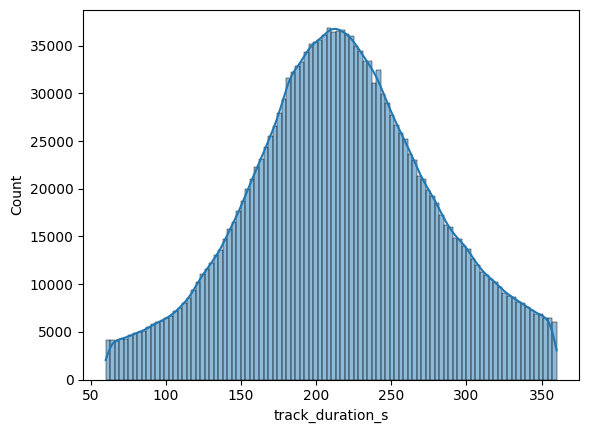

In [109]:
# histograma de la duracion de las canciones
sns.histplot(
  data = sampled_data,
  x = 'track_duration_s',
  bins = 100,
  kde = True,
)

<Axes: xlabel='track_popularity', ylabel='Count'>

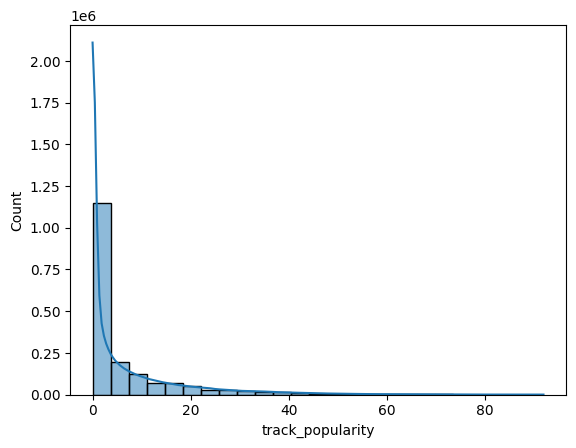

In [110]:
sns.histplot(
  data = sampled_data,
  x = 'track_popularity',
  bins = 25,
  kde = True,
)


<Axes: xlabel='album_release_year', ylabel='Count'>

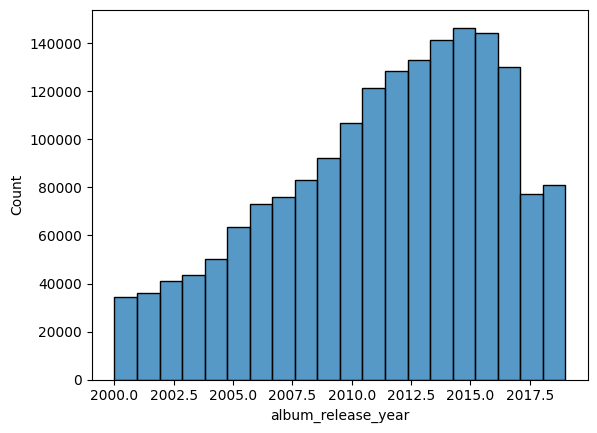

In [113]:
# plot release year
sns.histplot(
  data = sampled_data,
  x = 'album_release_year',
  bins = 20,
)

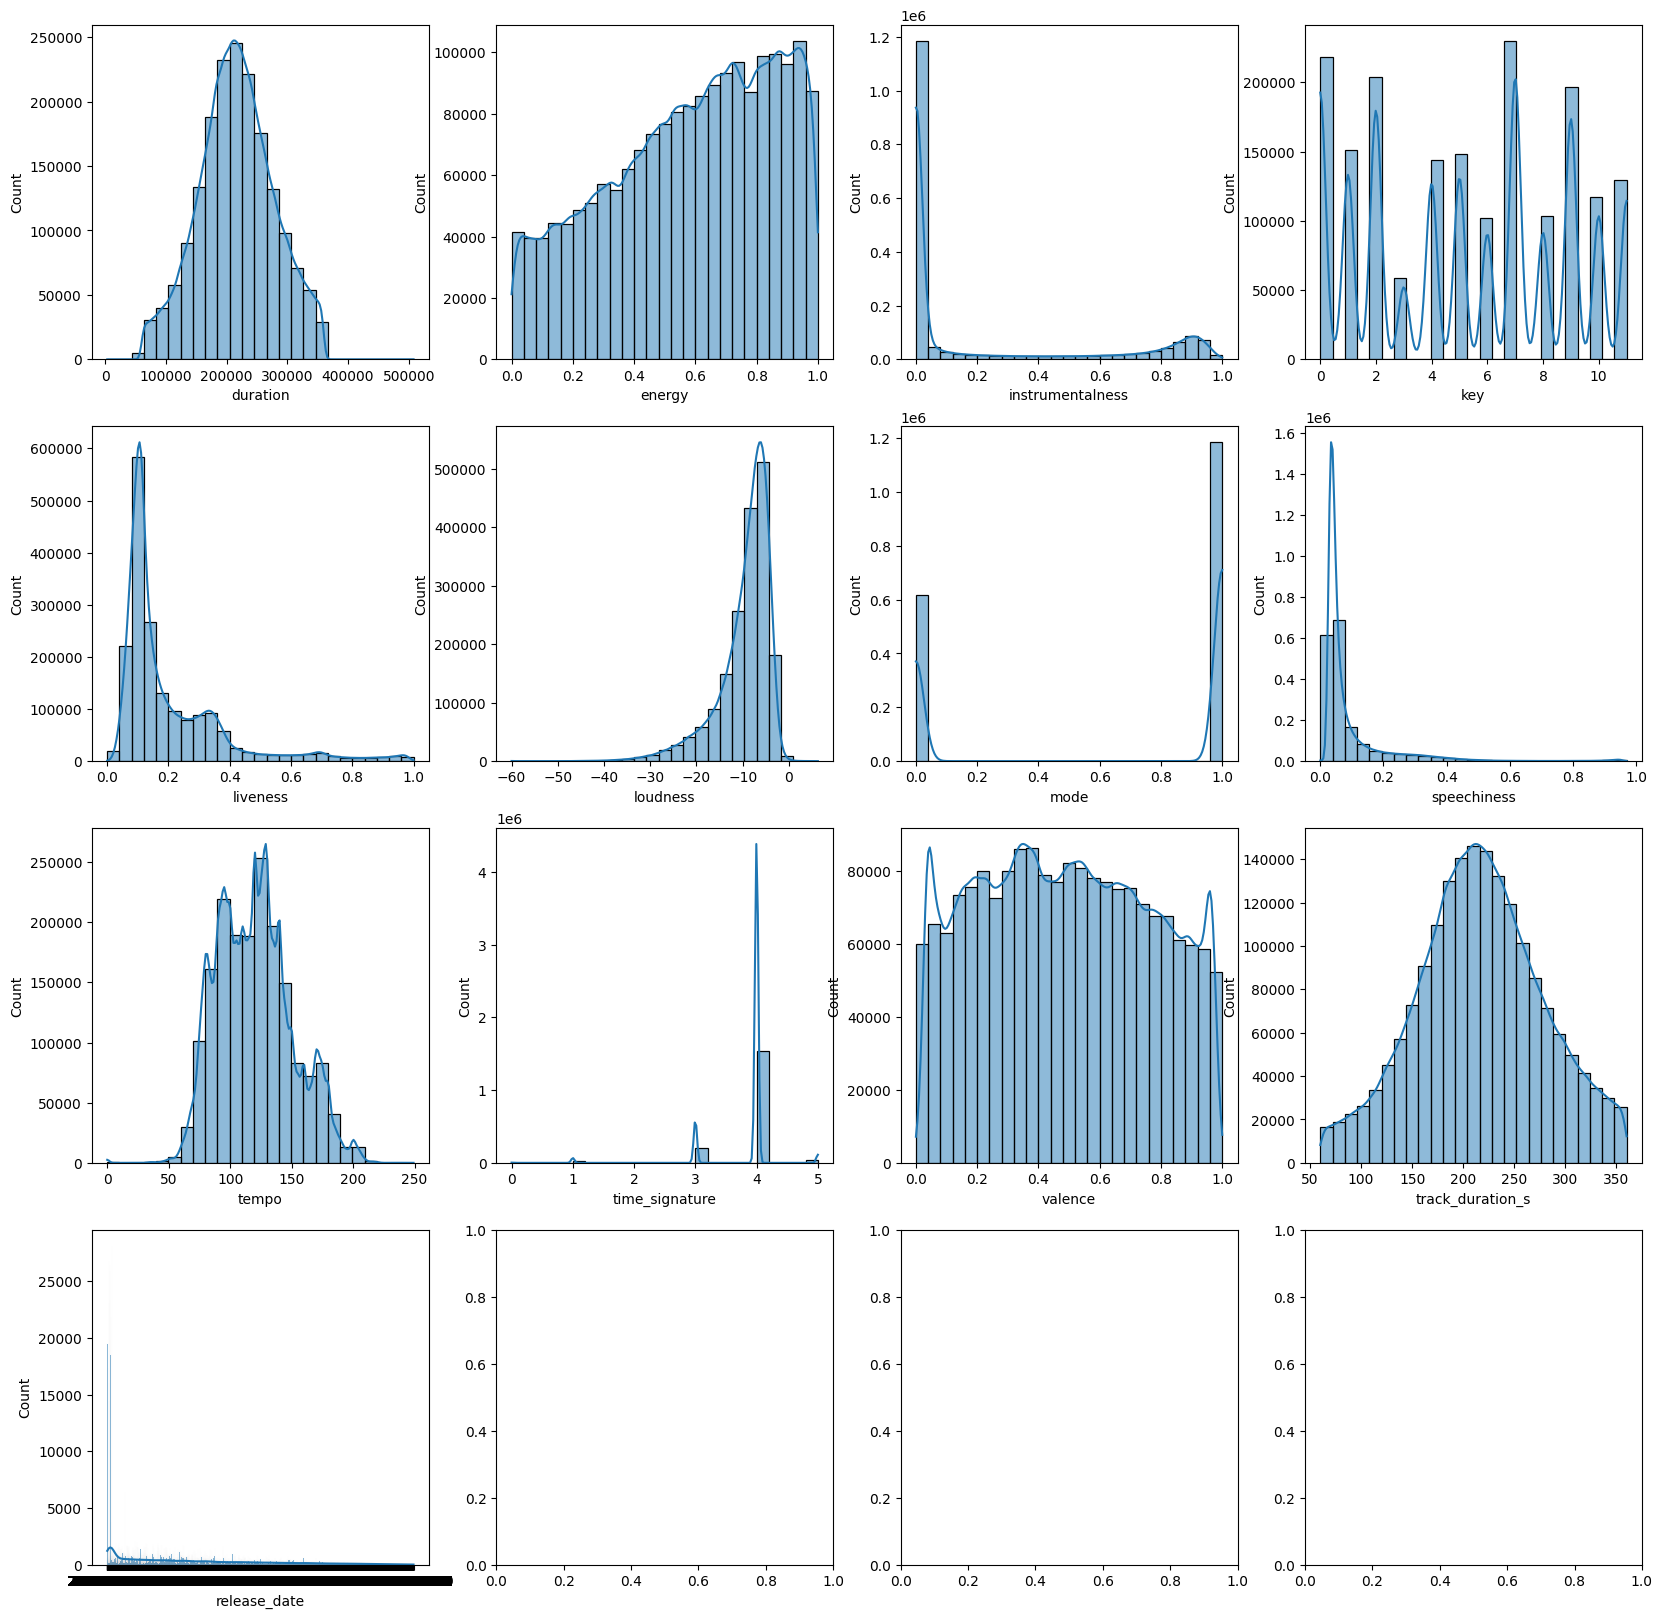

In [114]:
import matplotlib.pyplot as plt
# plot multiples histogramas (13 columnas/features)
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

columns = sampled_data.columns[-13:]
for i, col in enumerate(columns):
  sns.histplot(
    data = sampled_data,
    x = col,
    ax = axs[i // 4][i % 4],
    bins = 25,
    kde = True,
  )


In [115]:
# guardar la muestra
SAVE_SAMPLE = False
if SAVE_SAMPLE:
  sampled_data.to_csv(f'data/sampled_data_{fraction}.csv', index=False)